In [86]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
import albumentations as A
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import random, gc
import math
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion
seed=42

In [87]:
!pip install --upgrade charset-normalizer

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device : {device}")

current device : cuda


In [89]:
CFG = {
    'EPOCHS' : 90,
    'LEARNING_RATE' : 0.1,
    'NUM_CLASSES' : 1,
    'BATCH_SIZE' : 8,
    'SEED' : 42,
    'IMAGE_SIZE' : 256,
    'PATH' : 'E:/dtrc/segment_model.pth'
}

In [90]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [91]:
def init_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  np.random.seed(seed)

  random.seed(seed)

  gc.collect()
  torch.cuda.empty_cache()

init_seed(CFG['SEED'])

In [92]:
base_path = 'E:/dtrc/'
path_to_images = os.path.join(base_path, 'train_img')
path_to_masks = os.path.join(base_path, 'train_lab')

image_paths = sorted(glob(path_to_images + '/*.jpg'))
mask_paths = sorted(glob(path_to_masks + '/*.png'))

In [93]:
test_files = pd.read_csv(os.path.join('E:/dtrc/', 'test_files.csv'))
test_files

,ID,label
0,11194.jpg,0
1,11270-2.jpg,0
2,11296-6.jpg,0
3,11231-9.jpg,0
4,11249-6.jpg,0
...,...,...
232,IMG_6542-7.jpg,0
233,11295.jpg,0
234,11169-2.jpg,0
235,11247-8.jpg,0


In [94]:
print("img file counts : ", len(image_paths))
print("mask file counts : ", len(mask_paths))

img file counts :  300
mask file counts :  300


In [95]:
print("test file counts : ", len(test_files))

test file counts :  237


In [96]:
train_df = pd.DataFrame({'ID' : image_paths, 'label' : mask_paths})
train_df.head(5)

,ID,label
0,E:/dtrc/train_img\11111.jpg,E:/dtrc/train_lab\11111.png
1,E:/dtrc/train_img\11112.jpg,E:/dtrc/train_lab\11112.png
2,E:/dtrc/train_img\11113.jpg,E:/dtrc/train_lab\11113.png
3,E:/dtrc/train_img\11114.jpg,E:/dtrc/train_lab\11114.png
4,E:/dtrc/train_img\11115.jpg,E:/dtrc/train_lab\11115.png


In [97]:
test_files['ID'] = base_path + '/test_img/' + test_files['ID']
test_files.head(5)

,ID,label
0,E:/dtrc//test_img/11194.jpg,0
1,E:/dtrc//test_img/11270-2.jpg,0
2,E:/dtrc//test_img/11296-6.jpg,0
3,E:/dtrc//test_img/11231-9.jpg,0
4,E:/dtrc//test_img/11249-6.jpg,0


In [98]:
train, valid = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=seed)


print(f"splited train size : {len(train)}, \
 validation size: {len(valid)}, test size : {len(test_files)}")


splited train size : 270,  validation size: 30, test size : 237


In [109]:
train_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2(),
], is_check_shapes=False)

test_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

sharpening_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
    ToTensorV2()
], is_check_shapes=False)

colorjitter_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5),
                                           saturation=(0.5, 1.5), p=1.0),
    ToTensorV2(),
], is_check_shapes=False)

noise_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True,
                                          p=1.0),
    ToTensorV2()
], is_check_shapes=False)

superpixel_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.Superpixels(p=1.0),
    ToTensorV2()
], is_check_shapes=False)

In [110]:
rotate_transforms = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(0, 45), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms1 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(45, 90), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms2 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(90, 135), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms3 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(135, 180), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms4 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(180, 225), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms5 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(225, 270), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms6 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(315, 360), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms7 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(0, 45), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),    
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms8 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(45, 90), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms9 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(90, 135), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms10 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(135, 180), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms11 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(180, 225), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms12 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(225, 270), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms13 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(315, 360), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),    
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),    
    ToTensorV2()
], is_check_shapes=False)

In [111]:
class CrackDataset(Dataset):
  def __init__(self, dataset, train_mode=True, transforms=train_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
        image_path = row['ID']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        image = (image).astype(np.float32) # Normalize step
        image_tensor = self.transforms(image=image)

        mask_path = row['label']
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)


        mask_tensor = torch.as_tensor(mask[None], dtype=torch.int)
        return image_tensor, mask_tensor

    else:
        image_path = row['ID']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        image = (image).astype(np.float32)
        image_tensor = self.transforms(image=image)

        return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))
    images = [img['image'][None] for img in images]
    masks = [msk[None] for msk in masks]
    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks



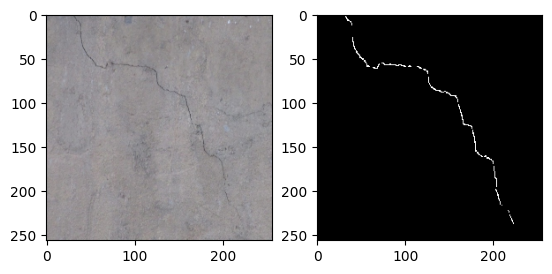

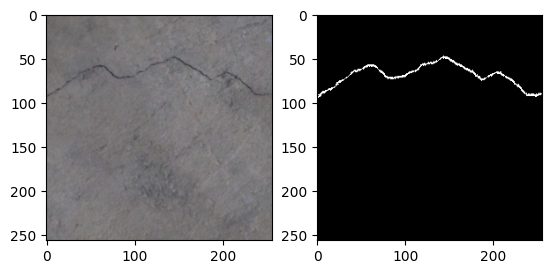

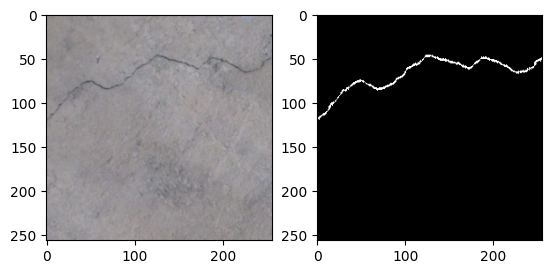

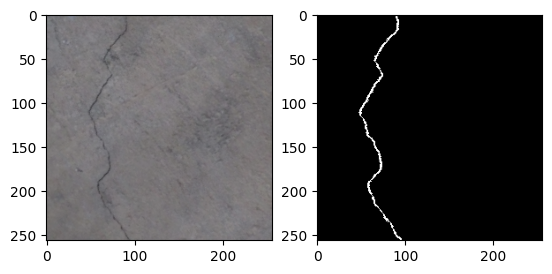

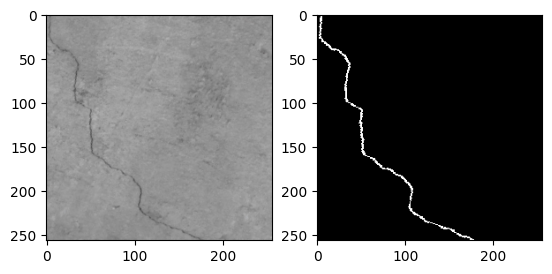

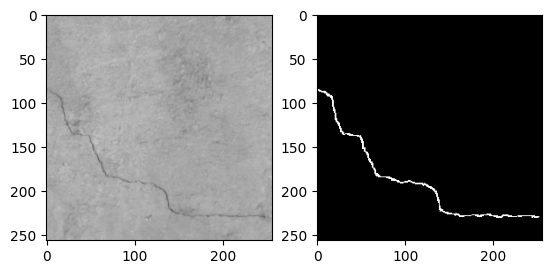

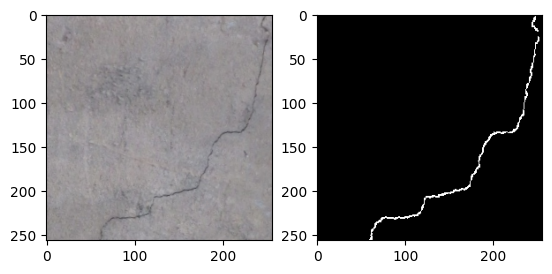

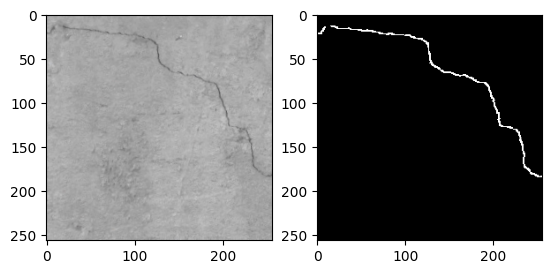

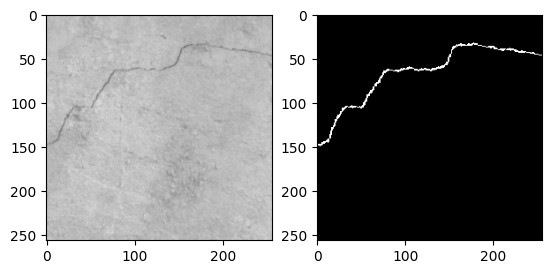

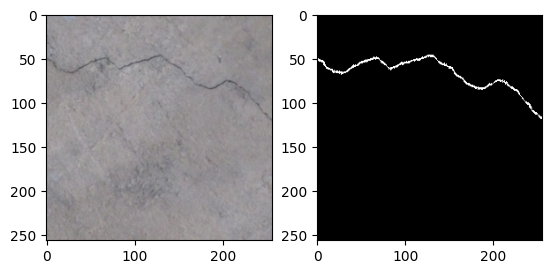

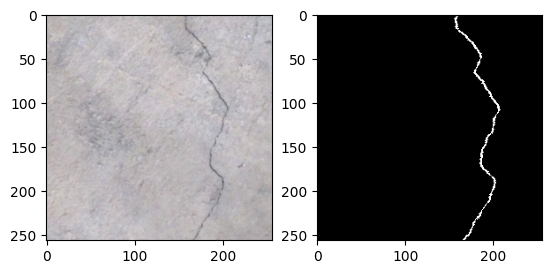

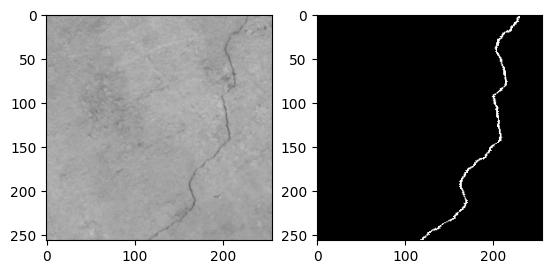

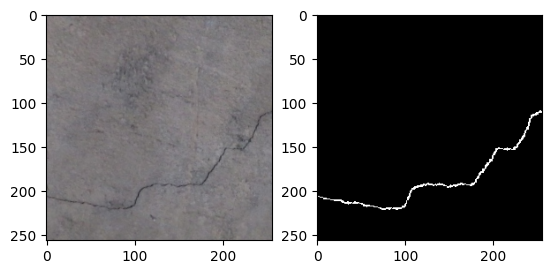

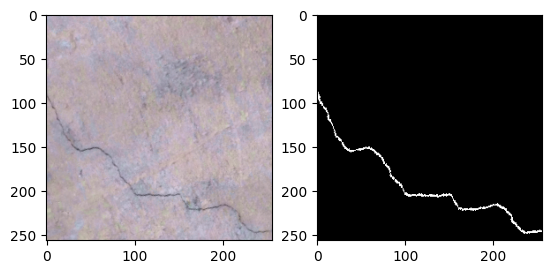

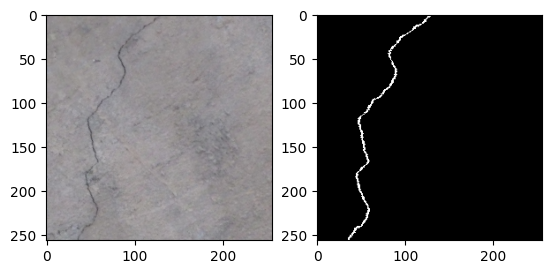

In [112]:
def drawing_tool(transforms, idx, grid):

  row = train.reset_index(drop=True).loc[idx].squeeze()
  image_path = row['ID']
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)

  
  mask_path = row['label']
  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  mask = mask.astype(np.uint8)
  
  transformed = transforms(image=image, mask=mask)
  
  image = transformed['image']
  mask = transformed['mask'].unsqueeze(0)
  
  # image = (image/255).float()
  # mask = mask.float()
  
  # print(np.unique(image.cpu().detach().numpy()))
  # print(np.unique(mask.cpu().detach().numpy()))

  plt.subplot(121)
  plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
  plt.subplot(122)
  plt.imshow(mask.cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
  plt.show()

img_num = 17
drawing_tool(train_transforms, img_num, 143)
drawing_tool(rotate_transforms, img_num, 1551)
drawing_tool(rotate_transforms1, img_num, 1551)
drawing_tool(rotate_transforms2, img_num, 1551)
drawing_tool(rotate_transforms3, img_num, 1551)
drawing_tool(rotate_transforms4, img_num, 1551)
drawing_tool(rotate_transforms5, img_num, 1551)
drawing_tool(rotate_transforms6, img_num, 1551)
drawing_tool(rotate_transforms7, img_num, 1551)
drawing_tool(rotate_transforms8, img_num, 1551)
drawing_tool(rotate_transforms9, img_num, 1551)
drawing_tool(rotate_transforms10, img_num, 1551)
drawing_tool(rotate_transforms11, img_num, 1551)
drawing_tool(rotate_transforms12, img_num, 1551)
drawing_tool(rotate_transforms13, img_num, 1551)

# drawing_tool(noise_transforms, img_num, 141)
# drawing_tool(colorjitter_transforms, img_num, 142)
# drawing_tool(superpixel_transforms, img_num, 144)
# drawing_tool(sharpening_transforms, img_num, 1)

In [113]:
# train_dataset = CrackDataset(train)
train_dataset = CrackDataset(train)
rotate_dataset = CrackDataset(train, transforms=rotate_transforms)
rotate_dataset1 = CrackDataset(train, transforms=rotate_transforms1)
rotate_dataset2 = CrackDataset(train, transforms=rotate_transforms2)
rotate_dataset3 = CrackDataset(train, transforms=rotate_transforms3)
rotate_dataset4 = CrackDataset(train, transforms=rotate_transforms4)
rotate_dataset5 = CrackDataset(train, transforms=rotate_transforms5)
rotate_dataset6 = CrackDataset(train, transforms=rotate_transforms6)
rotate_dataset7 = CrackDataset(train, transforms=rotate_transforms7)
rotate_dataset8 = CrackDataset(train, transforms=rotate_transforms8)
rotate_dataset9 = CrackDataset(train, transforms=rotate_transforms9)
rotate_dataset10 = CrackDataset(train, transforms=rotate_transforms10)
rotate_dataset11 = CrackDataset(train, transforms=rotate_transforms11)
rotate_dataset12 = CrackDataset(train, transforms=rotate_transforms12)
rotate_dataset13 = CrackDataset(train, transforms=rotate_transforms13)

In [114]:
valid_dataset = CrackDataset(valid)
test_dataset = CrackDataset(test_files, train_mode=False)

total_dataset = ConcatDataset([train_dataset,rotate_dataset,rotate_dataset1,
                               rotate_dataset2,rotate_dataset3,rotate_dataset4,
                               rotate_dataset5,rotate_dataset6,rotate_dataset7,
                               rotate_dataset8,rotate_dataset9,rotate_dataset10,
                               rotate_dataset11,rotate_dataset12,rotate_dataset13])

train_dataloader = DataLoader(total_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True,
                              collate_fn = train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                              collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [129]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
print(total_dataset[idx][0].values())

dict_values([tensor([[[110.1562, 119.8281, 115.8281,  ...,  96.1094,  96.6406,  96.2500],
         [127.9219, 124.6094, 120.3750,  ...,  92.7344,  90.7344, 104.5469],
         [129.7500, 132.5625, 131.0781,  ..., 101.4375,  95.8438,  93.1562],
         ...,
         [121.2500, 123.4531, 123.4375,  ..., 113.7969, 120.4531, 125.8438],
         [124.2500, 124.8438, 124.5938,  ..., 101.3125, 109.7031, 120.0469],
         [124.6719, 125.0781, 125.8125,  ...,  71.7344,  87.8594, 102.3750]],

        [[110.1562, 119.8281, 115.8281,  ...,  97.1094,  97.6406,  97.2500],
         [129.4219, 126.1094, 120.3750,  ...,  93.7344,  91.7344, 105.5469],
         [132.5000, 134.5625, 131.5781,  ..., 102.1875,  96.3438,  93.6562],
         ...,
         [121.2500, 123.4531, 123.4375,  ..., 113.2969, 119.9531, 125.3438],
         [124.2500, 124.8438, 124.5938,  ...,  99.5625, 107.9531, 118.2969],
         [124.6719, 125.0781, 125.8125,  ...,  67.7344,  83.8594,  98.3750]],

        [[110.1562, 119.8281, 1

In [136]:
@torch.no_grad()
def validate_test_image(model, dataset):
    idx = np.random.randint(len(dataset))
    dataset = dataset.reset_index(drop=True)
    row = dataset.loc[idx].squeeze()

    image = cv2.imread(row['ID'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    image = (image/255).astype(np.float32)
    image_tensor = train_transforms(image=image)['image'].unsqueeze(0).to(device)

    mask = cv2.imread(row['label'])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    model.eval()
    output_0, output = model(image_tensor)
    output = output.cpu().detach().numpy()[0][0]
    print(output)
    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')
    plt.subplot(133)
    plt.title('Predicted mask')
    plt.imshow(output, cmap='gray')
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)



In [137]:
from functools import partial

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_

class DistilledVisionTransformer(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=7, stride=2, padding=4),
            nn.BatchNorm2d(3),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 2, self.embed_dim))
        self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if self.num_classes > 0 else nn.Identity()

        trunc_normal_(self.dist_token, std=.02)
        trunc_normal_(self.pos_embed, std=.02)
        self.head_dist.apply(self._init_weights)

    def forward_features(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token
        B = x.shape[0]
        x = self.conv(x)
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0], x[:, 1]

    def forward(self, x):
        x, x_dist = self.forward_features(x)
        x = self.head(x)
        x_dist = self.head_dist(x_dist)
        if self.training:
            return x, x_dist
        else:
            # during inference, return the average of both classifier predictions
            return (x + x_dist) / 2


@register_model
def deit_tiny_patch16_256(pretrained=True,**kwargs):
    model = VisionTransformer(
        img_size=256, patch_size=16, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    if pretrained:
        ckpt = torch.load('pretrained/deit_tiny_patch16_256.pth')
        model.load_state_dict(ckpt['model'], strict=False)
    model.default_cfg = _cfg()
    return model
def deit_tiny_distilled_patch16_256(pretrained=True,**kwargs):
    model = DistilledVisionTransformer(
        img_size=256, patch_size=16, embed_dim=256, depth=12, num_heads=8, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    if pretrained:
        ckpt = torch.load('pretrained/deit_tiny_distilled_patch16_256.pth')
        model.load_state_dict(ckpt['model'], strict=False)
    model.default_cfg = _cfg()
    return model


## Specifically, the images in the ImageNet 2012 dataset ( Russakovsky et al., 2015 ) were resized to 256 × 256 , which were divided into 256 patches with the resolution of 16 × 16 .

In [138]:
from torchvision import models

class resnet34(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet34(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x0 = self.relu(x)
        feature1 = self.layer1(x0)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32

        return x0, feature1, feature2, feature3, feature4

class PyramidPoolingModule(nn.Module):
    def __init__(self, pyramids=[1, 2, 3, 6]):
        super(PyramidPoolingModule, self).__init__()
        self.pyramids = pyramids

    def forward(self, input):
        feat = input
        height, width = input.shape[2:]
        for bin_size in self.pyramids:
            x = F.adaptive_avg_pool2d(input, output_size=bin_size)
            x = F.interpolate(x, size=(height, width), mode='bilinear', align_corners=True)
            feat = feat + x
        return feat

class SEBlock(nn.Module):
    def __init__(self, channel, r=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Fusion
        y = torch.mul(x, y)
        return y

class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ResBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel)
        )

    def forward(self, x):
        out = self.left(x)
        residual = self.shortcut(x)
        out += residual
        return F.relu(out)

class FeatureFusion(nn.Module):
    """CFF Unit"""

    def __init__(self, in_channel, out_channel):
        super(FeatureFusion, self).__init__()
        self.fusion = ResBlock(in_channel, out_channel)

    def forward(self, x_high, x_low):
        x_low = F.interpolate(x_low, size=x_high.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x_low, x_high), dim=1)
        x = self.fusion(x)

        return x

class RPMBlock(nn.Module):
    def __init__(self, channels):
        super(RPMBlock, self).__init__()

        self.conv3 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1)

        self.gelu3 = nn.GELU()
        self.gelu1 = nn.GELU()

    def forward(self, x):
        x3 = self.conv3(x)
        x3 = self.gelu3(x3)
        x1 = self.conv1(x)
        x1 = self.gelu1(x1)
        out = x3 + x1
        return out

class DecoderBottleneckLayer(nn.Module):
    def __init__(self, in_channels, n_filters, use_transpose=True):
        super(DecoderBottleneckLayer, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.gelu1 = nn.GELU()

        if use_transpose:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1
                ),
                nn.BatchNorm2d(in_channels // 4),
                nn.GELU()
            )
        else:
            self.up = nn.Upsample(scale_factor=2, align_corners=True, mode="bilinear")

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.gelu3 = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.gelu1(x)
        x = self.up(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.gelu3(x)
        return x

In [139]:
class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=1, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2)

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x)))
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x)))
        x = F.relu(self.BNEn22(self.ConvEn22(x)))
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x)))
        x = F.relu(self.BNEn32(self.ConvEn32(x)))
        x = F.relu(self.BNEn33(self.ConvEn33(x)))
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x)))
        x = F.relu(self.BNEn42(self.ConvEn42(x)))
        x = F.relu(self.BNEn43(self.ConvEn43(x)))
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x)))
        x = F.relu(self.BNEn52(self.ConvEn52(x)))
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)
        return x

In [140]:
class DTrCNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(DTrCNet, self).__init__()
        self.n_class = n_classes
        self.inchannels = n_channels
        size = 256

        self.cnn = resnet34(pretrained=False)
        self.headpool = PyramidPoolingModule()

        transformer = deit_tiny_distilled_patch16_256(pretrained=False)
        self.patch_embed = transformer.patch_embed
        self.transformers = nn.ModuleList(
            [transformer.blocks[i] for i in range(12)]
        )
        self.se = SEBlock(channel=512)
        self.se1 = SEBlock(channel=64)
        self.se2 = SEBlock(channel=128)
        self.se3 = SEBlock(channel=256)

        self.fusion = FeatureFusion(in_channel=512 + size, out_channel=512)
        self.fusion1 = FeatureFusion(in_channel=64 + size, out_channel=64)
        self.fusion2 = FeatureFusion(in_channel=128 + size, out_channel=128)
        self.fusion3 = FeatureFusion(in_channel=256 + size, out_channel=256)

        self.RPMBlock1 = RPMBlock(channels=64)
        self.RPMBlock2 = RPMBlock(channels=128)
        self.RPMBlock3 = RPMBlock(channels=256)
        self.FAM1 = nn.ModuleList([self.RPMBlock1 for i in range(6)])
        self.FAM2 = nn.ModuleList([self.RPMBlock2 for i in range(4)])
        self.FAM3 = nn.ModuleList([self.RPMBlock3 for i in range(2)])

        filters = [64, 128, 256, 512]
        self.decoder4 = DecoderBottleneckLayer(filters[3], filters[2])
        self.decoder3 = DecoderBottleneckLayer(filters[2], filters[1])
        self.decoder2 = DecoderBottleneckLayer(filters[1], filters[0])
        self.decoder1 = DecoderBottleneckLayer(filters[0], filters[0])

        self.final_conv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.final_gelu1 = nn.GELU()
        self.final_conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.final_gelu2 = nn.GELU()
        self.final_conv3 = nn.Conv2d(32, n_classes, 3, padding=1)

        self.prev_cnn = nn.Conv2d(3, 3, kernel_size=3, padding=1)

    def forward(self, x):
        b, c, h, w = x.shape
        e0, e1, e2, e3, e4 = self.cnn(x)
        feature_cnn = self.headpool(e4)
        size = 256

        emb = self.patch_embed(self.prev_cnn(x))
        emb = self.transformers[0](emb)
        emb = self.transformers[1](emb)
        emb1 = self.transformers[2](emb)
        feature_tf1 = emb1.permute(0, 2, 1)
        feature_tf1 = feature_tf1.view(b, size, 16, 16)

        emb1 = self.transformers[3](emb1)
        emb1 = self.transformers[4](emb1)
        emb2 = self.transformers[5](emb1)
        feature_tf2 = emb2.permute(0, 2, 1)
        feature_tf2 = feature_tf2.view(b, size, 16, 16)

        emb2 = self.transformers[6](emb2)
        emb2 = self.transformers[7](emb2)
        emb3 = self.transformers[8](emb2)
        feature_tf3 = emb3.permute(0, 2, 1)
        feature_tf3 = feature_tf3.view(b, size, 16, 16)

        emb3 = self.transformers[9](emb3)
        emb3 = self.transformers[10](emb3)
        emb4 = self.transformers[11](emb3)

        feature_tf = emb4.permute(0, 2, 1)
        feature_tf = feature_tf.view(b, size, 16, 16)

        feature_cat = self.fusion(feature_cnn, feature_tf)
        feature_cat = self.se(feature_cat)

        e1 = self.fusion1(e1, feature_tf1)
        e2 = self.fusion2(e2, feature_tf2)
        e3 = self.fusion3(e3, feature_tf3)
        e1 = self.se1(e1)
        e2 = self.se2(e2)
        e3 = self.se3(e3)

        for i in range(2):
            e3 = self.FAM3[i](e3)
        for i in range(4):
            e2 = self.FAM2[i](e2)
        for i in range(6):
            e1 = self.FAM1[i](e1)

        d4 = self.decoder4(feature_cat) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        out1 = self.final_conv1(d2)
        out1 = self.final_gelu1(out1)
        out = self.final_conv2(out1)
        out = self.final_gelu2(out)
        out = self.final_conv3(out)
        return out

In [141]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, path=CFG['PATH']):
    self.path = path
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = np.inf
    self.early_stop = False

  def __call__(self, val_loss, model=None):
    if self.best_loss - val_loss > self.min_delta:
      torch.save(model.state_dict(), self.path)
      print(f'Model saved to : {self.path}')
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True


In [142]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #print(inputs, targets)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, outputs, targets):
        return 0.75 * self.bce(outputs, targets) + 0.25 * self.dice(outputs, targets)

In [143]:
import json
previous_metrics = [(0,0,0,0)]
json.dump(previous_metrics, open(f"history.json", "w"))

In [144]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.float().to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()

import torchmetrics
import json
accuracy = torchmetrics.Accuracy(task='binary').to(device)
precision = torchmetrics.Precision(task='binary').to(device)
recall = torchmetrics.Recall(task='binary').to(device)
f1 = torchmetrics.F1Score(task='binary').to(device)
Auroc = torchmetrics.AUROC(task='binary').to(device)
IoU = torchmetrics.JaccardIndex(task='binary').to(device)
Dice = torchmetrics.Dice().to(device)

previous_metrics = [(0,0,0,0)]
try:
    old_model_metrics = json.load(open('./history.json', 'r'))
except:
    pass
max_test_sample=5
def test(dataloader, model, loss_fn, current_epoch):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0,0

    test_loss /= size
    correct /= size
    index_x = 0
    total_pred = torch.Tensor().to(device)
    total_y = torch.Tensor().bool().to(device)

    if current_epoch % 10 == 0:
        fig, (ax) = plt.subplots(4, max_test_sample, figsize=(40,12))
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.to(device)
            pred = model(X)
            pred = pred.to(device)

            total_pred = torch.cat((total_pred, pred), dim=0)
            total_y = torch.cat((total_y, y), dim=0)
            if current_epoch % 10 == 0:
                if index_x < 5:
                    heatmap_np = pred.cpu().detach().numpy()
                    heatmap_np = heatmap_np[0, 0, :, :]
                    # nomalize
                    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min())

                    fig.colorbar(ax[0,index_x].imshow(X.cpu().detach().numpy()[0, 0, :, :]), ax=ax[0,index_x])
                    fig.colorbar(ax[1,index_x].imshow(y.cpu().detach().numpy()[0, 0, :, :]), ax=ax[1,index_x])
                    fig.colorbar(ax[2,index_x].imshow(heatmap_np), ax=ax[2,index_x])
                    ax[3,2].set_title("> 0.5")
                    fig.colorbar(ax[3,index_x].imshow(heatmap_np > 0.5), ax=ax[3,index_x])

                    ax[0,index_x].axis('off')
                    ax[1,index_x].axis('off')
                    ax[2,index_x].axis('off')
                    ax[3,index_x].axis('off')
                index_x += 1



    print("----------------------------------------------------------------------------------")
    json.dump(previous_metrics, open(f"history.json", "w"))

In [145]:
import time
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# model = get_efficientunet_b7(out_channels=1, concat_input=True, pretrained=True).to(device)

# inp = torch.randn(1, 3, 512, 512)
model = DTrCNet().to(device)

loss_fn = DiceBCELoss()
start_time = time.time()
# Define your optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
# Set the epoch milestones at which to adjust the learning rate
# milestones = [20, 50, 100]

epochs = 90
# Set the factor by which the learning rate will decay
gamma = 0.1

# Calculate the step size based on the number of epochs
# step_size = int(epochs / len(milestones))

# Create the StepLR scheduler
lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, power=0.9, total_iters=CFG['EPOCHS'])


In [ ]:
import gc

gc.collect()
for current_epoch in range(epochs):
    print(f"Epoch {current_epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer,lr_scheduler)
    test(valid_dataloader, model, loss_fn, current_epoch)
    if (current_epoch+1)% 45 == 0:
        if current_epoch != 0:
            torch.save(model.state_dict(), f'E:/dtrc/model{current_epoch}.pth')

print("Done!")

Epoch 1
-------------------------------
loss: 0.779638  [    8/ 4050]
loss: 0.902457  [  408/ 4050]
loss: 0.772849  [  808/ 4050]
loss: 0.766268  [ 1208/ 4050]
loss: 0.766811  [ 1608/ 4050]
loss: 0.767140  [ 2008/ 4050]
loss: 0.758367  [ 2408/ 4050]
loss: 0.752049  [ 2808/ 4050]
loss: 0.619738  [ 3208/ 4050]
loss: 0.466942  [ 3608/ 4050]
loss: 0.331104  [ 4008/ 4050]
----------------------------------------------------------------------------------
Epoch 2
-------------------------------
loss: 0.352085  [    8/ 4050]
loss: 0.338390  [  408/ 4050]
loss: 0.330992  [  808/ 4050]
loss: 0.422916  [ 1208/ 4050]
loss: 0.385985  [ 1608/ 4050]
loss: 0.344364  [ 2008/ 4050]
loss: 0.340848  [ 2408/ 4050]
loss: 0.368138  [ 2808/ 4050]
loss: 0.322286  [ 3208/ 4050]
loss: 0.319126  [ 3608/ 4050]
loss: 0.312251  [ 4008/ 4050]
----------------------------------------------------------------------------------
Epoch 3
-------------------------------
loss: 0.314688  [    8/ 4050]
loss: 0.334568  [  408/ 

In [ ]:
y_pred = []
test_model = DTrCNet().to(device)
test_model = torch.load('E:/dtrc/model44.pth')
my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))

# test_model.eval()
model.eval()
for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
    output = model(images['image'].to(device))
    
    output = np.where(output.cpu().detach().numpy().astype(np.float32) > 0.5, 1, 0)

    plt.imshow(output[0][0]*255, cmap='gray')
    plt.show()
    output = output[0][0].reshape(-1, )
    img = list(map(int, output.tolist()))
    label = "".join(map(str, img))

    chunk_size = 8
    chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

    for i in range(len(chunks)):
        y_pred.append([path+str(i), "2" + chunks[i]])
        
submission = pd.DataFrame(y_pred, columns=['ID', 'label'])
submission['label'] = submission['label'].astype(int)
submission.to_csv('./results.csv', index=False)

In [ ]:
y_pred = []
test_model = DTrCNet().to(device)
test_model = torch.load('E:/dtrc/model89.pth')
my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))

# test_model.eval()
model.eval()
for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
    output = model(images['image'].to(device))
    
    output = np.where(output.cpu().detach().numpy().astype(np.float32) > 0.5, 1, 0)

    plt.imshow(output[0][0]*255, cmap='gray')
    plt.show()
    output = output[0][0].reshape(-1, )
    img = list(map(int, output.tolist()))
    label = "".join(map(str, img))

    chunk_size = 8
    chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

    for i in range(len(chunks)):
        y_pred.append([path+str(i), "2" + chunks[i]])
submission = pd.DataFrame(y_pred, columns=['ID', 'label'])
submission['label'] = submission['label'].astype(int)
submission.to_csv('./results.csv', index=False)